### 1. Importing packages

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

### 2. Loading datasets

In [ ]:
XY_train = pd.read_csv('application_train.csv', index_col=0)

# splitting features and response in train dataset
Y_train = XY_train[['TARGET']]
X_train = XY_train.drop('TARGET', axis=1)

X_test = pd.read_csv('application_test.csv', index_col=0)

# combining train and test features
X_combined0 = pd.concat([X_train, X_test], axis=0)
X_combined0.shape

(356255, 120)

### 3. Feature engineering

In [ ]:
# removing columns with missing values more than 20%
X_null = X_combined0.isnull().sum(axis=0)
max_na = X_combined0.shape[0] * 0.2

cols = [col for col in X_combined0.columns if X_null[col] <= max_na]
X_combined1 = X_combined0[cols]
X_combined1.shape

(356255, 70)

In [ ]:
X_combined1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 100002 to 456250
Data columns (total 70 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NAME_CONTRACT_TYPE           356255 non-null  object 
 1   CODE_GENDER                  356255 non-null  object 
 2   FLAG_OWN_CAR                 356255 non-null  object 
 3   FLAG_OWN_REALTY              356255 non-null  object 
 4   CNT_CHILDREN                 356255 non-null  int64  
 5   AMT_INCOME_TOTAL             356255 non-null  float64
 6   AMT_CREDIT                   356255 non-null  float64
 7   AMT_ANNUITY                  356219 non-null  float64
 8   AMT_GOODS_PRICE              355977 non-null  float64
 9   NAME_TYPE_SUITE              354052 non-null  object 
 10  NAME_INCOME_TYPE             356255 non-null  object 
 11  NAME_EDUCATION_TYPE          356255 non-null  object 
 12  NAME_FAMILY_STATUS           356255 non-null  object 

In [ ]:
# getting no. of cardinal (numeric) columns and categorical columns
num_cols = X_combined1.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_combined1.select_dtypes(include='object').columns.tolist()
        
print(f'Cardinal columns = {len(num_cols)}')
print(f'Categorical columns = {len(cat_cols)}')

Cardinal columns = 59
Categorical columns = 11


In [ ]:
# imputing cardinal columns
num_imputer = SimpleImputer(strategy='mean')
X_combined2 = X_combined1.copy()
X_combined2[num_cols] = num_imputer.fit_transform(X_combined1[num_cols])

# imputing categorical columns
for col in cat_cols:
    mode = X_combined2[col].mode()[0]
    X_combined2[col].fillna(value=mode)

X_combined2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 100002 to 456250
Data columns (total 70 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NAME_CONTRACT_TYPE           356255 non-null  object 
 1   CODE_GENDER                  356255 non-null  object 
 2   FLAG_OWN_CAR                 356255 non-null  object 
 3   FLAG_OWN_REALTY              356255 non-null  object 
 4   CNT_CHILDREN                 356255 non-null  float64
 5   AMT_INCOME_TOTAL             356255 non-null  float64
 6   AMT_CREDIT                   356255 non-null  float64
 7   AMT_ANNUITY                  356255 non-null  float64
 8   AMT_GOODS_PRICE              356255 non-null  float64
 9   NAME_TYPE_SUITE              354052 non-null  object 
 10  NAME_INCOME_TYPE             356255 non-null  object 
 11  NAME_EDUCATION_TYPE          356255 non-null  object 
 12  NAME_FAMILY_STATUS           356255 non-null  object 

In [ ]:
# imputing 'NAME_TYPE_SUITE'
cat_imputer = SimpleImputer(strategy='most_frequent')
X_combined2['NAME_TYPE_SUITE'] = cat_imputer.fit_transform(X_combined1[['NAME_TYPE_SUITE']])
X_combined2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 100002 to 456250
Data columns (total 70 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NAME_CONTRACT_TYPE           356255 non-null  object 
 1   CODE_GENDER                  356255 non-null  object 
 2   FLAG_OWN_CAR                 356255 non-null  object 
 3   FLAG_OWN_REALTY              356255 non-null  object 
 4   CNT_CHILDREN                 356255 non-null  float64
 5   AMT_INCOME_TOTAL             356255 non-null  float64
 6   AMT_CREDIT                   356255 non-null  float64
 7   AMT_ANNUITY                  356255 non-null  float64
 8   AMT_GOODS_PRICE              356255 non-null  float64
 9   NAME_TYPE_SUITE              356255 non-null  object 
 10  NAME_INCOME_TYPE             356255 non-null  object 
 11  NAME_EDUCATION_TYPE          356255 non-null  object 
 12  NAME_FAMILY_STATUS           356255 non-null  object 

In [ ]:
# creating dummies for categorical columns
X_combined3 = pd.get_dummies(X_combined2)

### 4. Performance evaluation

In [ ]:
# function for performance evaluation
def model_perf(model, X, Y, prefix=''):
    Yhat = model.predict_proba(X)[:,1]
    auc = roc_auc_score(Y, Yhat)
    print(f'{prefix} AUROC score = {auc:.3f}')

# function for training and validating model
def model_fit_perf(model, X_all, Y_all, prefix=''):
    X_trn, X_val, Y_trn, Y_val = train_test_split(X_all, Y_all, test_size=0.2, 
                                                  random_state=42)
    model.fit(X_trn, Y_trn)
    print(prefix)
    model_perf(model, X_trn, Y_trn, '  Training   ')
    model_perf(model, X_val, Y_val, '  Validation ')

### 5. Modeling

In [ ]:
# function to split combined dataset into train and test
def split_train_test(X_combined, n):
    X_train = X_combined.iloc[:n,:]
    X_test = X_combined.iloc[n:,:]
    return X_train, X_test

In [ ]:
X_train, X_test = split_train_test(X_combined3, X_train.shape[0])

In [ ]:
# creating models
xgb_c = XGBClassifier()
lgbm_c = LGBMClassifier()
rf_c = RandomForestClassifier(n_estimators=50)

estms = [('xgb_c', xgb_c), ('lgbm_c', lgbm_c), ('rf_c', rf_c)]
s_c = StackingClassifier(estimators=estms, final_estimator=LGBMClassifier())

In [ ]:
# training and validating models
models = ['XGBoost', 'LGBM', 'Random Forest', 'Stacking']
model_fit_perf(xgb_c, X_train, Y_train, models[0])
model_fit_perf(lgbm_c, X_train, Y_train, models[1])
model_fit_perf(rf_c, X_train, Y_train, models[2])
model_fit_perf(s_c, X_train, Y_train, models[3])

XGBoost
  Training    AUROC score = 0.753
  Validation  AUROC score = 0.746
LGBM
  Training    AUROC score = 0.790
  Validation  AUROC score = 0.751
Random Forest
  Training    AUROC score = 1.000
  Validation  AUROC score = 0.701
Stacking
  Training    AUROC score = 0.878
  Validation  AUROC score = 0.748


### 6. Prediction

In [ ]:
# predicting responses for test dataset using lgbm (best Val AUROC score)
target_pred = lgbm_c.predict_proba(X_test)

sub_df = pd.read_csv('sample_submission.csv', index_col=0)
sub_df['TARGET'] = target_pred[:,1]

sub_df.to_csv('sub-home-credit.csv')

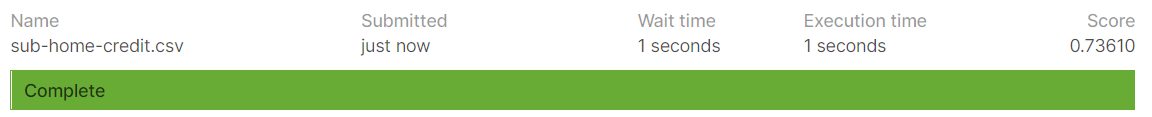